# Exercise 3
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU. 

**Make sure you use the best practices you learned in class**.

In this exercise, you will accomplish the following:
1. Train a convolutional network using PyTorch and evaluate it.
2. Visualize a neural network layer and interpet thier meaning.

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as T
from scipy.ndimage.filters import gaussian_filter1d

SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is {device}")

Device is cuda


# Convolutional Neural Network - Classifiying CIFAR-10 (60 points)

So far we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very messy for large complex networks.

Thankfully, we can use **automatic differentiation** to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph. Nodes in the graph will be Tensors,
and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

If we want to compute gradients with respect to some Tensor, then we set `requires_grad=True` when constructing that Tensor. Any PyTorch operations on that Tensor will cause a computational graph to be constructed, allowing us to later perform backpropagation through the graph. If `x` is a Tensor with `requires_grad=True`, then after backpropagation `x.grad` will be another Tensor holding the gradient of `x`.

Sometimes you may wish to prevent PyTorch from building computational graphs when performing certain operations on Tensors with `requires_grad=True`; for example, we usually don't want to backpropagate through the weight update steps when evaluating a neural network. In such scenarios we can use the `torch.no_grad()` context manager to prevent the construction of a computational graph.


## Data Preprocessing

In [3]:
transform = T.Compose(
    [T.ToTensor(),
     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Image shape:  torch.Size([3, 32, 32])
       dog        car      horse       bird


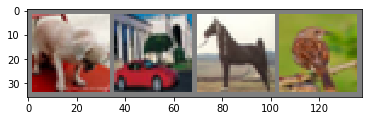

In [4]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

## Construct a CNN in PyTorch - 30 points

In the following class, initiate your different layers in the `__init__` method and define your architecture in the `forward` method. Make sure the `forward` method has a single return value. 

1. Make good use of the documentation and experiment will different layers, activations and architectures, batch sizes, regularization, filter sizes, dimensions, number of layers and whatever you learned in class. 
1. Use your intuition from the previous exercises and additional sources such as the Piazza, papers, etc. - do not try to perform a massive grid search.
1. **Your model must end with two linear layers. (with activations between them)**.
1. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
1. Make sure your code runs reasonably fast (~30 minutes on CPU and ~5 minutes on GPU).
1. Use the best architecture you find and train it for 5-10 epochs. 
1. Explain why you chose that architecture and why you think it performs better than other networks you tried. Cite papers, blogs, MOOCs, online guides and every other source you used during optimization.
1. Visualize the loss and accuracy of your network during training. You can use matplotlib or seaborn.
1. **You should get close to 75% accuracy, explain you results and include visualizations for the full 30 points**.

**My Answer:** My final architecture is as follows:
conv(3, 64) -> norm -> relu -> pool ->
conv(64, 128) -> norm -> relu -> pool ->
conv(128, 256) -> norm -> relu -> pool ->
conv(256, 512) -> norm -> relu -> pool ->
fc((2)(2)(512), 1024) -> relu -> dropout(0.5) ->
fc(1024, 10) -> softmax.
running this network for 6 epochs resulted in a validation accuracy of almost 80%

As part of finding the best architecture, i've experiment a variety of architecture's combinations. Below I elaborate about the process I went through and the insights regarding each variable:

**epochs:** *initially i've used 10 epochs, but over-time when my network improved i've felt there is a generalization gap between training and testing. Therfore i've decided to lower the num of epochs to 6, which resulted with good validation accuracy with a reasonable gap between the training accuracy to the validation accuracy, and a faster computational time. increasing the epochs num, increased the generalization gap and the computational time, with no significant change for the validation accuracy, while decreasing the epochs num, came with a small but significant change in the validation accuracy.*

**num of conv layers:** *i've started with 2 conv layers and gradually increased it to 4 layers, which improved the model's validation accuracy to almost 80%, while staying within the given timeframe. increasing the number of layers further improved the model but exceed the given timeframe and therefore i've decided to stay with 4 layers*

**norm:** *as studied in the training and optimization class, batch normalization prevents exploding and vanishing gradients and accelerates convergence of training, therefore i added a normalizaion after each of the conv layers*

**conv dimensions:** *gradually increasing the dimension from 64 to 128, 256 and 512 gave me the best result in the given timeframe. increasing it further exceed the given timeframe. also, gradually increasing the channel size is aligned with the architectures we learned about*

**fc dimensions:** *as suggested in AlexNet and VGG, before my final 10 classes fully connected layer, i've initially used a fully connected layer with a dimension of 4096, which gave me better results than using a dimension of 2048 or 1024. but to stay with the given timeframe i've decided to downgrade it to 1024*

**dropout:** *in the original paper that proposed dropout layers, by Hinton (2012), dropout (with p=0.5) was used on the fully connected layers before the output. it was not used on the convolutional layers. therefore, as suggested i added a dropout of 0.5 before the final fully connected layer.* 

**softmax and cross entropy:** *as studied in the multiclass classification class, we typically combine the softmax and cross-entropy into softmax-cross entropy function, therfore i used it as the final activation.*

**pooling:** *initially i've tried an architecture with no pooling, which resulted with a high memory and too many paramters. As i gradually added more pooling layers, the computation time reduced drastically. eventually i've decided to go with a total of 4 pooling layers which lower the 32x32 input dimension down to 2x2, which drastically lower the number of parameters for the first fully connected layer*

**stride and padding:** *as we learned, the conv layer output size is ((N-F+2P)/stride)+1. for convenience, in order to keep the output dimension equal with the 3x3 filter size i've used a padding and a stride of 1. If placed in the above formula we are resulted with ((N-3+2(1))/1)+1 which is equal to N, as wanted.*

**filter size:** *as we learned in class smaller filters gives less computation time, fewer parameters, more nonlinearity and have a good representational power. therefore i've used a small kernel filters of 3x3 as suggested in the VGG architecture*

**activation:** *as AlexNet architecture suggested i've decided to use the ReLU nonlinearity function and as stated aboce i used softmax for the final layer*

Also, here is a list of refrences i've used during the process:

https://stats.stackexchange.com/questions/240305/where-should-i-place-dropout-layers-in-a-neural-network

https://www.udemy.com/course/pytorch-for-deep-learning-with-python-bootcamp/

https://www.udemy.com/course/advanced-computer-vision/

https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout

https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html

Class presentations 3-7


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the different layers you wish to use in your network.            #
        # This method has no return value.                                          #
        #############################################################################

        self.conv_block = nn.Sequential(
              nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
              nn.BatchNorm2d(64),
              nn.ReLU(inplace=True),      
              nn.MaxPool2d(kernel_size=2, stride=2),

              nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
              nn.BatchNorm2d(128),
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=2, stride=2),

              nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
              nn.BatchNorm2d(256),
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=2, stride=2),
  
              nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
              nn.BatchNorm2d(512),
              nn.ReLU(inplace=True),
              nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer1 = nn.Linear(2*2*512, 1024)
        self.fc_layer2 = nn.Linear(1024, 10)

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def feature_extraction(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Pass through the image x thghrough all layers except the last one         #
        # and the activation between it and the previous linear layer.              #
        # This way we can extract the feature space that the network generetes      #
        # before the final prediction.                                              #
        #############################################################################

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

        x = self.conv_block(x)
        x = x.view(-1, 2*2*512)
        x = self.fc_layer1(x)
        return x

    def forward(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and obtain class predictions.                                     #
        # This function returns the predication of your model.                      #
        #############################################################################

        x = F.relu(self.feature_extraction(x))
        x = nn.Dropout2d(p=0.5)(x)
        x = F.log_softmax(self.fc_layer2(x), dim=1)
        return x

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

net = Net().to(device)
print(net)
criterion = None
optimizer = None
#############################################################################
# TO DO:                                                                    #
# Define the loss function and optimizer.                                   #
# You are encouraged to experiment with different optimizers                #
#############################################################################

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

Net(
  (conv_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, aff

epoch:  0  batch:  100 [  6400/50000]  loss: 1.62967658 accuracy:  29.172%
epoch:  0  batch:  200 [ 12800/50000]  loss: 1.32326519 accuracy:  34.898%
epoch:  0  batch:  300 [ 19200/50000]  loss: 1.38001919 accuracy:  39.172%
epoch:  0  batch:  400 [ 25600/50000]  loss: 1.19478595 accuracy:  42.414%
epoch:  0  batch:  500 [ 32000/50000]  loss: 1.17378187 accuracy:  44.841%
epoch:  0  batch:  600 [ 38400/50000]  loss: 1.15022719 accuracy:  46.773%
epoch:  0  batch:  700 [ 44800/50000]  loss: 1.19569838 accuracy:  48.614%
epoch:  1  batch:  100 [  6400/50000]  loss: 1.16340196 accuracy:  62.281%
epoch:  1  batch:  200 [ 12800/50000]  loss: 0.90553927 accuracy:  64.062%
epoch:  1  batch:  300 [ 19200/50000]  loss: 0.94717461 accuracy:  64.490%
epoch:  1  batch:  400 [ 25600/50000]  loss: 1.04795110 accuracy:  64.945%
epoch:  1  batch:  500 [ 32000/50000]  loss: 0.78931504 accuracy:  65.500%
epoch:  1  batch:  600 [ 38400/50000]  loss: 1.27190101 accuracy:  65.904%
epoch:  1  batch:  700 [ 

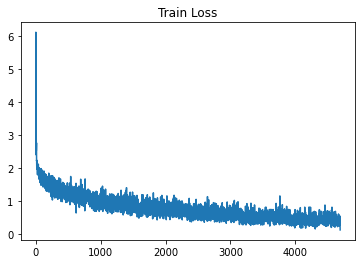

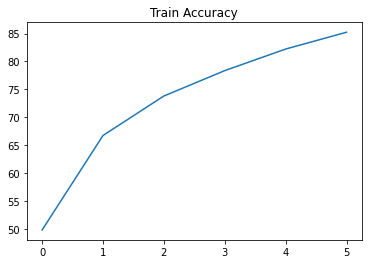

In [6]:
#############################################################################
# TO DO:                                                                    #
# Define the training loop as seen in class and as demonstrated in the      #
# documentation. Note, if you are using GPU, make sure your code runs on    #
# CPU also. Code that cannot run will not be tested.                        # 
#############################################################################
import time
start_time = time.time()

epochs = 6
train_correct_history = []
loss_history = []

for i in range(epochs):
    train_correct = 0
    test_correct = 0
    
    for batch_num, (X_train, y_train) in enumerate(trainloader):
        batch_num += 1
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        y_pred = net(X_train)
        loss = criterion(y_pred, y_train)
 
        predicted = torch.max(y_pred.data, 1)[1]
        batch_correct = (predicted == y_train).sum()
        train_correct += batch_correct

        optimizer.zero_grad()
        loss.backward()
        loss_history.append(loss.item())

        optimizer.step()
        
        if batch_num%100 == 0:
            print(f'epoch: {i:2}  batch: {batch_num:4} [{64*batch_num:6}/50000]  loss: {loss.item():10.8f} \
accuracy: {train_correct.item()*100/(64*batch_num):7.3f}%')

    train_correct_history.append(train_correct.item())

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed   

plt.plot(loss_history, label='training loss')
plt.title('Train Loss')
plt.show()

plt.plot([t/500 for t in train_correct_history], label='training accuracy')
plt.title('Train Accuracy')
plt.show()

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

GroundTruth:      cat    ship    ship   plane
Predicted:        cat     car    ship   plane


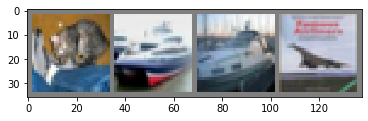

In [7]:
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%7s' % classes[labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)
print('Predicted:   ', ' '.join('%7s' % classes[predicted[j]]for j in range(4)))

## Model Class Performance Evaluation - 15 points

1. Calculate the confusion matrix for the model. You are allowed to use loops.
1. Calculate and print the model's overall accuracy and the accuracy for each class.
1. Plot the confusion matrix with matplotlib where the y axis represents the real category and the x axis represents the predicted category and print the accuracies. (make sure the rows and columns are labeled with the proper class names).
1. **Explain the results**: what can you learn from the confusion matrix? Why do you need additional evaluation methods other than accuracy?

**My answer:** *as we can see from the plot, the model's predicted labels are very similar to the true labels, which is highlighted on the plot's diagonal. additional evaluation methods other than accuracy would be able to give us more insights regarding the model's prediction. particularly, by confusion matrix, we could discover where the model has more struggle to predict accurately. for example, in our case, there is a high score in the intersection between cat and dog, and between car and truck which suggest the model misclassify dogs with cats and misclassify cars with trucks which is quite reasonable*

In [8]:
confusion_matrix = np.zeros([10,10], int)
#############################################################################
# TO DO:                                                                    #
# Define the evaluation loop as seen in class and as demonstrated in the    #
# documentation and use the confusion matrix to evaluate your model.        # 
#############################################################################

with torch.no_grad():

    net.eval()
    test_correct = 0
    for X_test, y_test in testloader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)

        y_val = net(X_test)
        predicted = torch.max(y_val,1)[1]
        test_correct += (predicted == y_test).sum()

        for label_index, label in enumerate(y_test):
            confusion_matrix[label.item(), predicted[label_index].item()] += 1 

model_accuracy = test_correct.item()*100/(len(testset))

print(f'Model accuracy on test set: {round(model_accuracy, 2)}%')

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

Model accuracy on test set: 77.92%


plane accuracy: 85.2%
car accuracy: 88.1%
bird accuracy: 61.7%
cat accuracy: 55.5%
deer accuracy: 77.0%
dog accuracy: 69.4%
frog accuracy: 84.5%
horse accuracy: 89.3%
ship accuracy: 74.4%
truck accuracy: 94.1%


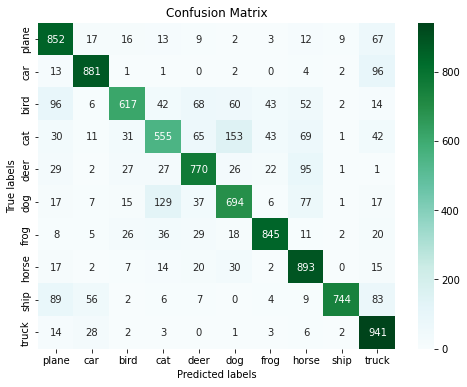

In [9]:
#############################################################################
# TO DO:                                                                    #
# plot the confusion matrix, use labels to show what is the predicted\actual#
# and label each row column with the correct class description              #
# documentation and use the confusion matrix to evaluate your model.        # 
#############################################################################
import seaborn as sns

plt.figure(figsize=(8, 6))
ax = plt.subplot()
sns.heatmap(confusion_matrix, annot=True, fmt='g', ax=ax, cmap='BuGn')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)

for i, r in enumerate(confusion_matrix):
    print(f'{classes[i]} accuracy: {round(r[i]/np.sum(r)*100, 2)}%')

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Visualizing and Evaluating the Model's latent space - 15 points

In order to furether evaluate our network's model performance, we would like to visualize its feature's latent space in 2d and see which classes are close to each other. In order to accomplish this we are going to use the "T-SNE" algorithem to project our feature space to a lower dimension.

1. Set the model to evaluation mode and use the feature_extraction method to get the feature representation of the 10,000 test set images using the feature_extraction method.

2. Read the documentation of "https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html" and use T-SNE to project the images from the high dimensional feature space to the lower dimensional feature space.

3. Visualize the image distrubtion in the 2d space by plotting each image with the color of its label (total 10 labels\colors) using matplotlib scatter plot.

4. What can you learn from the plot? is it consistent with the confusion matrix?


(10000, 2)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


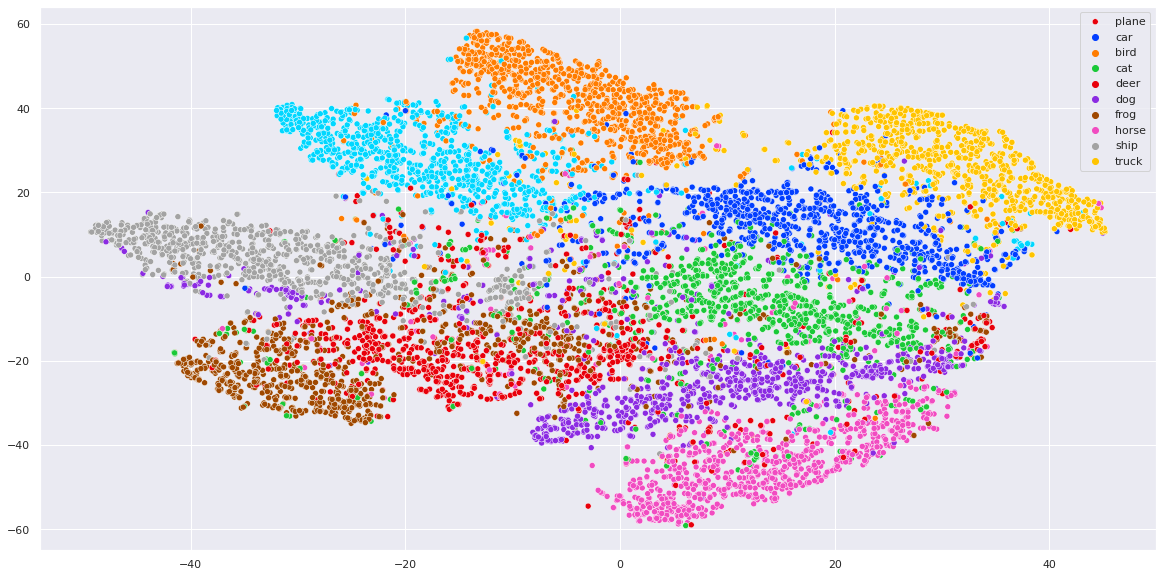

In [10]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

net.eval()

outputs = []
labels = []

with torch.no_grad():
    for (X_test, y_test) in testloader:
        X_test = X_test.to(device)
        y_pred = net.feature_extraction(X_test)

        outputs.append(y_pred.cpu())
        labels.append(y_test)

outputs = torch.cat(outputs, dim = 0)
labels = torch.cat(labels, dim = 0)

tsne_result = TSNE(n_components=2, learning_rate=50, init='random').fit_transform(outputs)
print(tsne_result.shape)

sns.set(rc={'figure.figsize':(20,10)})
palette = sns.color_palette("bright", 10)
sns.scatterplot(tsne_result[:,0], tsne_result[:,1], hue=labels, legend='full', palette=palette)
plt.legend(labels=classes)


**Your answer to 4 goes here**

**My answer:** *First, after adding the hue parameter, we can definitely see that each class has its own cluster. Furthermore, we can see that classes which the model misclassify between according to the confusion matrix, such as dog with cat and car with truck, are located close to each other in the T-SNE visualization, which suggest the that it is indeed consistent with the confusion matrix findings.*

# Network Visualization - 40 points

In this part we are going to load a pretrained model classifier model called SqueezeNet and explore the meaning (and some would say intent) behind the calculation in its layer's.

1. **Saliency Maps**: Saliency maps are a quick way to tell which part of the image influenced the classification decision made by the network.
1. **Fooling Images**: We can perturb an input image so that it appears the same to humans, but will be misclassified by the pretrained network.



In [11]:
!wget https://raw.githubusercontent.com/Oringa/pytorch_workshop/master/imagenet_val_25.npz

--2021-12-09 20:45:26--  https://raw.githubusercontent.com/Oringa/pytorch_workshop/master/imagenet_val_25.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3940548 (3.8M) [application/octet-stream]
Saving to: ‘imagenet_val_25.npz.4’

imagenet_val_25.npz 100%[===================>]   3.76M  --.-KB/s    in 0.07s   

2021-12-09 20:45:26 (51.2 MB/s) - ‘imagenet_val_25.npz.4’ saved [3940548/3940548]




## Helper Functions

Our pretrained model was trained on images that had been preprocessed by subtracting the per-color mean and dividing by the per-color standard deviation. We define a few helper functions for performing and undoing this preprocessing. 

In [12]:
def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
    
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

## Pretrained model

For all of our image generation experiments, we will start with a convolutional neural network which was pretrained to perform image classification on ImageNet. We can use any model here, but for the purposes of this assignment we will use [SqueezeNet](https://arxiv.org/abs/1602.07360), which achieves accuracies comparable to AlexNet but with a significantly reduced parameter count and computational complexity.

Using SqueezeNet rather than AlexNet, VGG or ResNet means that we can easily perform all image generation experiments on CPU.

In [13]:
# Download and load the pretrained SqueezeNet model.
model = torchvision.models.squeezenet1_1(pretrained=True)

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False

## Load some ImageNet images

We have provided a few example images from the validation set of the ImageNet ILSVRC 2012 Classification dataset. Since they come from the validation set, our pretrained model did not see these images during training.

In [14]:
import numpy as np

def load_imagenet_val(num=None):
    """Load a handful of validation images from ImageNet.
    Inputs:
    - num: Number of images to load (max of 25)
    Returns:
    - X: numpy array with shape [num, 224, 224, 3]
    - y: numpy array of integer image labels, shape [num]
    - class_names: dict mapping integer label to class name
    """
    imagenet_fn = 'imagenet_val_25.npz'
    f = np.load(imagenet_fn, allow_pickle=True)
    X = f['X']
    y = f['y']
    class_names = f['label_map'].item()
    if num is not None:
        X = X[:num]
        y = y[:num]
    return X, y, class_names

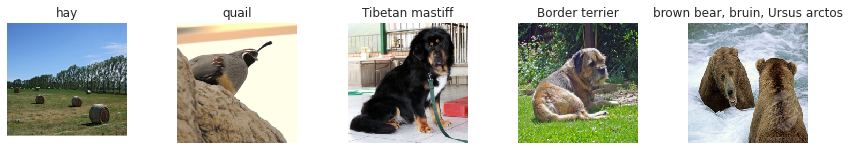

In [15]:
X, y, class_names = load_imagenet_val(num=5)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

## Saliency Maps
A saliency map tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape (3, H, W) then this gradient will also have shape (3, H, W); for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape (H, W) and all entries are nonnegative.

### PyTorch gather method
If `s` is an numpy array of shape `(N, C)` and `y` is a numpy array of shape `(N,)` containing integers `0 <= y[i] < C`, then `s[np.arange(N), y]` is a numpy array of shape `(N,)` which selects one element from each element in `s` using the indices in `y`.

In PyTorch you can perform the same operation using the `gather()` method. If `s` is a PyTorch Tensor of shape `(N, C)` and `y` is a PyTorch Tensor of shape `(N,)` containing longs in the range `0 <= y[i] < C`, then `s.gather(1, y.view(-1, 1)).squeeze()` will be a PyTorch Tensor of shape `(N,)` containing one entry from each row of `s`, selected according to the indices in `y`.



In [16]:
def gather_example():
    N, C = 4, 5
    s = torch.randn(N, C)
    y = torch.LongTensor([1, 2, 1, 3])
    print(s)
    print(y)
    print(s.gather(1, y.view(-1, 1)).squeeze())
gather_example()

tensor([[-0.4095, -0.0165, -0.1081,  1.8926, -0.5765],
        [-0.6600,  0.0965, -0.5263, -0.4554,  0.2369],
        [ 0.8494,  1.1723, -0.0227, -0.1852, -1.1908],
        [ 0.3871,  2.0383,  0.0502, -0.8190,  1.2434]])
tensor([1, 2, 1, 3])
tensor([-0.0165, -0.5263,  1.1723, -0.8190])


In [17]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    saliency = None
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores (we'll combine losses across a batch by summing), and then compute  #
    # the gradients with a backward pass.                                        #
    ##############################################################################
    
    model.eval() 
    X = X.requires_grad_()
    outputs = model(X)
    scores = outputs.gather(1, y.view(-1, 1)).squeeze() 
    ones_scores = torch.ones(scores.size())
    scores.backward(ones_scores)
    saliency = torch.max(X.grad.abs(), dim=1)[0].squeeze()

    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

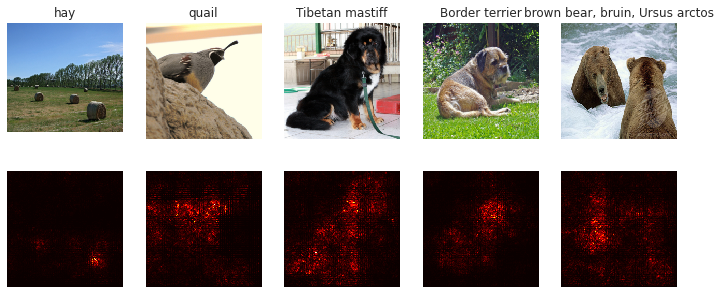

In [18]:
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)
    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

show_saliency_maps(X, y)

## Fooling classifiers

We can also use image gradients to generate "fooling images". Given an image and a target class, we can perform gradient ascent over the image to maximize the target class, stopping when the network classifies the image as the target class. Implement the following function to generate fooling images.

In [19]:
def make_fooling_image(X, target_y, model):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image; Tensor of shape (1, 3, 224, 224)
    - target_y: An integer in the range [0, 1000)
    - model: A pretrained CNN

    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    # Initialize our fooling image to the input image, and make it require gradient
    X_fooling = X.clone()
    X_fooling = X_fooling.requires_grad_()
    
    learning_rate = 1
    ##############################################################################
    # TODO: Generate a fooling image X_fooling that the model will classify as   #
    # the class target_y. You should perform gradient ascent on the score of the #
    # target class, stopping when the model is fooled.                           #
    # When computing an update step, first normalize the gradient:               #
    #   dX = learning_rate * g / ||g||_2                                         #
    #                                                                            #
    # You should write a training loop.                                          #
    #                                                                            #
    # HINT: For most examples, you should be able to generate a fooling image    #
    # in fewer than 100 iterations of gradient ascent.                           #
    # You can print your progress over iterations to check your algorithm.       #
    ##############################################################################
    
    prediction = None
    iteration = 0

    while prediction != target_y:
        outputs = model(X_fooling)
        prediction = torch.argmax(outputs, dim=1)
        score = outputs[0, target_y]
        score.backward()

        g = X_fooling.grad
        X_fooling.data += learning_rate * (g / g.norm())  

        iteration += 1
        
    print(f'successfully generate a fooling image in {iteration} iterations')

    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return X_fooling

In [20]:
idx = 2
target_y = 443

X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
X_fooling = make_fooling_image(X_tensor[idx:idx+1], target_y, model)

scores = model(X_fooling)
assert target_y == scores.data.max(1)[1][0].item(), 'The model is not fooled!'

successfully generate a fooling image in 16 iterations


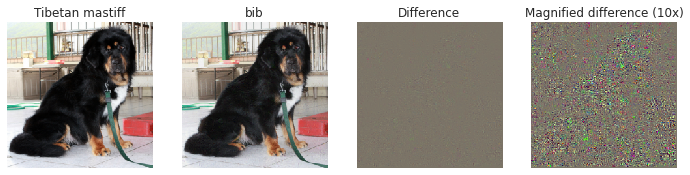

In [21]:
X_fooling_np = deprocess(X_fooling.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()

The End